In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
dallara_data_df = read_csv("climate_data/dallara_data.csv", delimiter=";")
dallara_data = dallara_data_df.values

contrails_data_altitude = dallara_data[0:12, 1]
contrails_data_forcing_factor = dallara_data[0:12, 0]
nox_o3_data_altitude = dallara_data[12:25, 1]
nox_o3_data_forcing_factor = dallara_data[12:25, 0]
nox_ch4_data_altitude = dallara_data[25:, 1]
nox_ch4_data_forcing_factor = dallara_data[25:, 0]

In [3]:
def ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails):
    ratr = 6.25e14 * sensitivity_rf_contrails * ratio_erf_rf_contrails * efficacy_erf_contrails / time_horizon**0.843
    return ratr

def ratr_nox_o3(time_horizon, sensitivity_rf_nox_o3, ratio_erf_rf_nox_o3, efficacy_erf_nox_o3):
    ratr = 6.25e14 * sensitivity_rf_nox_o3 * ratio_erf_rf_nox_o3 * efficacy_erf_nox_o3 / time_horizon**0.843
    return ratr

def ratr_nox_ch4(time_horizon, sensitivity_rf_nox_ch4, ratio_erf_rf_nox_ch4, efficacy_erf_nox_ch4):
    ratr = 6.84e11 * sensitivity_rf_nox_ch4 * ratio_erf_rf_nox_ch4 * efficacy_erf_nox_ch4 * time_horizon**(0.113 - 0.103 * np.log(time_horizon))
    return ratr

In [4]:
scaling_factor_altitude_contrails = interp1d(
    contrails_data_altitude,
    contrails_data_forcing_factor,
    kind='linear',
)

scaling_factor_altitude_nox_o3 = interp1d(
    nox_o3_data_altitude,
    nox_o3_data_forcing_factor,
    kind='linear',
)

scaling_factor_altitude_nox_ch4 = interp1d(
    nox_ch4_data_altitude,
    nox_ch4_data_forcing_factor,
    kind='linear',
)

In [5]:
time_horizon = 100
sensitivity_rf_contrails = 2.23e-12
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1
sensitivity_rf_nox_o3 = 25.1e-12 * (14/46)
ratio_erf_rf_nox_o3 = 1.37
efficacy_erf_nox_o3 = 1
sensitivity_rf_nox_ch4 = -0.83e-9
ratio_erf_rf_nox_ch4 = 1.18
efficacy_erf_nox_ch4 = 1

In [14]:
altitude = list(range(20000, 41000, 500))
ratr_contrails_altitude = np.zeros(len(altitude))
ratr_nox_o3_altitude = np.zeros(len(altitude))
ratr_nox_ch4_altitude = np.zeros(len(altitude))

for k in range(0, len(altitude)):
    scaling_factor_contrails = scaling_factor_altitude_contrails(altitude[k])
    scaling_factor_nox_o3 = scaling_factor_altitude_nox_o3(altitude[k])
    scaling_factor_nox_ch4 = scaling_factor_altitude_nox_ch4(altitude[k])
    ratr_contrails_altitude[k] = ratr_contrails(time_horizon, scaling_factor_contrails * sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails)
    ratr_nox_o3_altitude[k] = ratr_nox_o3(time_horizon, scaling_factor_nox_o3 * sensitivity_rf_nox_o3, ratio_erf_rf_nox_o3, efficacy_erf_nox_o3)
    ratr_nox_ch4_altitude[k] = ratr_nox_ch4(time_horizon, scaling_factor_nox_ch4 * sensitivity_rf_nox_ch4, ratio_erf_rf_nox_ch4, efficacy_erf_nox_ch4)

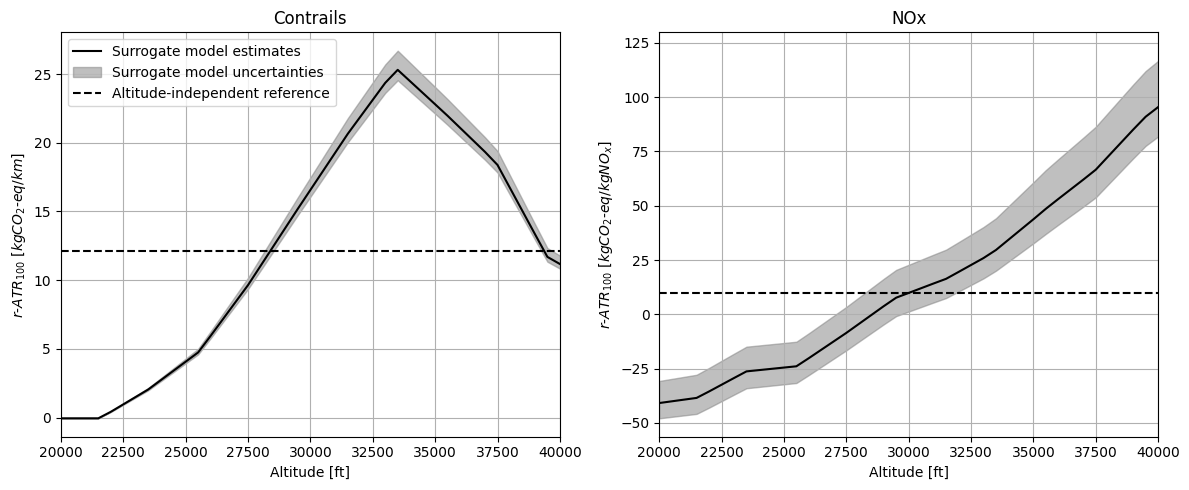

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(altitude, ratr_contrails_altitude, label="Surrogate model estimates", color="black")
axs[0].fill_between(altitude, ratr_contrails_altitude*1.055, ratr_contrails_altitude*0.97, alpha = 0.5, label="Surrogate model uncertainties", color="grey")
axs[0].plot(altitude, 12.09 * np.ones(len(altitude)), label="Altitude-independent reference", color="black", linestyle="--")
axs[0].set_xlabel('Altitude [ft]')
axs[0].set_ylabel(r'$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km$]')
axs[0].set_title("Contrails")
axs[0].legend()
axs[0].grid()
axs[0].set_xlim(20000, 40000)

# --- Figure 2 (identique ou modifiable) ---
axs[1].plot(altitude, ratr_nox_o3_altitude + ratr_nox_ch4_altitude, label="Surrogate model estimates", color="black")
axs[1].fill_between(altitude, ratr_nox_o3_altitude*1.055 + ratr_nox_ch4_altitude*0.95, ratr_nox_o3_altitude*0.97 + ratr_nox_ch4_altitude*1.04, alpha = 0.5, label="Surrogate model uncertainties", color="grey")
axs[1].plot(altitude, 9.95 * np.ones(len(altitude)), label="Altitude-independent reference", color="black", linestyle="--")
#axs[1].plot(altitude, ratr_nox_o3_altitude, label="Ozone-related - Surrogate model estimate", color="C1")
#axs[1].fill_between(altitude, ratr_nox_o3_altitude*1.055, ratr_nox_o3_altitude*0.97, alpha = 0.5, label="Ozone-related - Surrogate model uncertainty", color="C1")
#axs[1].plot(altitude, ratr_nox_ch4_altitude, label="Methane-related - Surrogate model estimate", color="C2")
#axs[1].fill_between(altitude, ratr_nox_ch4_altitude*1.04, ratr_nox_ch4_altitude*0.95, alpha = 0.5, label="Methane-related - Surrogate model uncertainty", color="C2")
axs[1].set_xlabel('Altitude [ft]')
axs[1].set_ylabel(r'$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/kgNO_x$]')
axs[1].set_title("NOx")
axs[1].grid()
axs[1].set_xlim(20000, 40000)

plt.tight_layout()
plt.savefig("altitude.pdf")
plt.show()